In [ ]:
import qics as qc
from qics.cones import OpPerspecEpi, NonNegOrthant
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from ising.pauli import SiteBasis

In [3]:
def basis_commutator(o1, o2):
    commutation_table = [
        [(0, ''),(0, ''),(0, ''),(0, '')],
        [(0, ''),(0, ''),(2, 'Z'),(-2, 'Y')],
        [(0, ''),(-2, 'Z'),(0, ''),(2, 'X')],
        [(0, ''),(2, 'Y'),(-2, 'X'),(0, '')],
    ] # everything here must be multiplied with 1j
    return commutation_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def basis_anticommutator(o1, o2):
    anticommutation_table = [
        [(2, 'I'),(2, 'X'),(2, 'Y'),(2, 'Z')],
        [(2, 'X'),(2, 'I'),(0, ''),(0, '')],
        [(2, 'Y'),(0, ''),(2, 'I'),(0, '')],
        [(2, 'Z'),(0, ''),(0, ''),(2, 'I')],
    ]
    return anticommutation_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def basis_product(o1, o2):
    product_table = [
        [(1, 'I'),(1, 'X'),(1, 'Y'),(1, 'Z')],
        [(1, 'X'),(1, 'I'),(1j, 'Z'),(-1j, 'Y')],
        [(1, 'Y'),(-1j, 'Z'),(1, 'I'),(1j, 'X')],
        [(1, 'Z'),(1j, 'Y'),(-1j, 'X'),(1, 'I')],
    ]
    return product_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def anticommutator(word1, word2):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    if len(word1) == 1:
        c, o = basis_anticommutator(word1, word2)
        return Counter({o: c})
    expression = Counter()
    e_1 = commutator(word1[0], word2[0])
    e_2 = commutator(word1[1:], word2[1:])
    e_3 = anticommutator(word1[0], word2[0])
    e_4 = anticommutator(word1[1:], word2[1:])
    for o1, c1 in e_1.items():
        for o2, c2 in e_2.items():
            expression[o1 + o2] -= 0.5 * c1 * c2 # since c1 * 1j * c2 * 1j = - c1 * c2
    for o1, c1 in e_3.items():
        for o2, c2 in e_4.items():
            expression[o1 + o2] += 0.5 * c1 * c2
    return expression

def commutator(word1: str, word2: str):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    if len(word1) == 1:
        c, o = basis_commutator(word1, word2)
        return Counter({o: c})
    expression = Counter()
    e_1 = commutator(word1[0], word2[0])
    e_2 = anticommutator(word1[1:], word2[1:])
    e_3 = anticommutator(word1[0], word2[0])
    e_4 = commutator(word1[1:], word2[1:])
    for o1, c1 in e_1.items():
        for o2, c2 in e_2.items():
            expression[o1 + o2] += 0.5 * c1 * c2
    for o1, c1 in e_3.items():
        for o2, c2 in e_4.items():
            expression[o1 + o2] += 0.5 * c1 * c2
    # whatever is returned, needs to be multiplied by 1j
    return expression

def product(word1, word2):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    word = []
    coeff = 1
    for o1, o2 in zip(word1, word2):
        c, op = basis_product(o1, o2)
        word.append(op)
        coeff *= c
    # coeff can be real or complex
    return (coeff, ''.join(word))

<h2>Directly in QICS:</h2>

In [4]:
def schwinger_dyson(basis, n, hamil: list, word1: str):
    C = np.zeros((1, n + 6 * n * n))
    expression = Counter()
    for coeff, w in hamil:
        terms = commutator(w, word1)
        for op, c in terms.items():
            if len(op) != len(word1):
                continue
            expression[op] += coeff * c
    for op, c in expression.items():
        C[0, basis.rank(op)] += c
    return C

def get_A_term(basis, i, j):
    ops1 = basis.unrank(i)
    ops2 = basis.unrank(j)
    coeff, word = product(ops1, ops2)
    return coeff, basis.rank(word)

def get_B_term(basis, i, j):
    ops1 = basis.unrank(i)
    ops2 = basis.unrank(j)
    coeff, word = product(ops2, ops1)
    return coeff, basis.rank(word)

def get_C_term(basis, i, j, hamil):
    ops1 = basis.unrank(i)
    ops2 = basis.unrank(j)
    termsd = Counter()
    for coeff, w in hamil:
        terms = commutator(w, ops2)
        for op, c in terms.items():
            if len(op) != len(w):
                continue
            c2, op2 = product(ops1, op)
            termsd[op2] += coeff * c * c2 * 1j
    return termsd

In [15]:
def construct_hamil(L, h):
    hamil = []
    for i in range(L):
        t1 = None
        if i<L-1:
            t1 = 'I'*i + 'XX' + 'I'*(L-i-2)
        else:
            t1 = 'X' + 'I'*(L-2) + 'X'
        t2 = 'I'*i+'Z'+'I'*(L-i-1)
        hamil.extend([(-1, t1), (-h, t2)])
    if L == 2:
        hamil = [(-h, 'IZ'), (-h, 'ZI'), (-1, 'XX')]
    return hamil

def construct_lin(L, basis, hamil, beta):
    n = basis.size()
    cons = [np.zeros((1, n + 6 * n * n))]
    cons[0][0, basis.rank('I' * L)] = 1.0
    for i in range(1, n):
        cons.append(schwinger_dyson(basis, n, hamil, basis.unrank(i)))
    for i in range(n):
        for j in range(n):
            # 6 rows
            # beta C
            termsd = get_C_term(basis, i, j, hamil)
            # beta C real
            u = np.zeros((1, n + 6 * n * n))
            u[0, n + 2 * n * i + 2 * j] = -1
            for op, c in termsd.items():
                p = basis.rank(op)
                u[0, p] += beta * np.real(c)
            cons.append(u)
            # beta C imag
            u = np.zeros((1, n + 6 * n * n))
            u[0, n + 2 * n * i + 2 * j + 1] = -1
            for op, c in termsd.items():
                p = basis.rank(op)
                u[0, p] += beta * np.imag(c)
            cons.append(u)
            # A
            c, p = get_A_term(basis, i, j)
            # A real
            u = np.zeros((1, n + 6 * n * n))
            u[0, n + 2 * n * n + 2 * n * i + 2 * j] = -1
            u[0, p] += np.real(c)
            cons.append(u)
            # A imag
            u = np.zeros((1, n + 6 * n * n))
            u[0, n + 2 * n * n + 2 * n * i + 2 * j + 1] = -1
            u[0, p] += np.imag(c)
            cons.append(u)
            # B
            c, p = get_B_term(basis, i, j)
            # B real
            u = np.zeros((1, n + 6 * n * n))
            u[0, n + 4 * n * n + 2 * n * i + 2 * j] = -1
            u[0, p] += np.real(c)
            cons.append(u)
            # B imag
            u = np.zeros((1, n + 6 * n * n))
            u[0, n + 4 * n * n + 2 * n * i + 2 * j + 1] = -1
            u[0, p] += np.imag(c)
            cons.append(u)
    A = np.vstack(cons)
    b = np.zeros((A.shape[0], 1))
    b[0, 0] = 1.0 # Normalization
    return A, b

# Remember that all expectation values are real in the Ising model
def create_problem(L, beta):
    basis = SiteBasis(L)
    n = basis.size()
    H = construct_hamil(L, 1)
    A, b = construct_lin(L, basis, H, beta)
    G = np.hstack([np.zeros((6 * n * n, n)), np.eye(6 * n * n)])
    h = np.zeros((6 * n * n, 1))
    c = np.zeros((n + 6 * n * n, 1))
    c[basis.rank('XX'+'I'*(L-2)), 0] = c[basis.rank('Z'+'I'*(L-1)), 0] = -L
    if L == 2:
        c[basis.rank('XX'), 0] = -1.0
        c[basis.rank('ZI'), 0] = -2.0
    cones = [OpPerspecEpi(n, func="log", iscomplex=True)]
    return A, b, G, h, c, cones

def solve(L, betas, verbose=True):
    mins, maxs = np.zeros_like(betas), np.zeros_like(betas)
    for i, beta in enumerate(betas):
        if verbose:
            print(f'Solving for T={1/beta}, i={i}:')
        # Note the sign for G, since QICS requires h - Gx in K
        A, b, G, h, c, cones = create_problem(L, beta)
        minmodel = qc.Model(c=c, A=A, b=b, G=-G, h=h, cones=cones)
        maxmodel = qc.Model(c=-c, A=A, b=b, G=-G, h=h, cones=cones)
        minsolver = qc.Solver(minmodel, verbose=2)
        maxsolver = qc.Solver(maxmodel, verbose=2)
        mininfo = minsolver.solve()
        maxinfo = maxsolver.solve()
        E_min = mininfo['p_obj']
        E_max = maxinfo['p_obj']
        if verbose:
            # print('\tSolution status: (min = ' + mininfo['sol_status'] + ', ' + mininfo['exit_status'] +
            #        ') --- (max = ' + maxinfo['sol_status'] + ', ' + maxinfo['exit_status'] + ')')
            # minxVec = mininfo['x_opt']
            # maxxVec = maxinfo['x_opt']
            # print(f'\tSolution vector for min: {minxVec}')
            # print(f'\tSolution vector for max: {maxxVec}')
            print(f'\tE_min = {E_min}')
            print(f'\tE_max = {E_max}')
        mins[i], maxs[i] = E_min, E_max
    return mins, maxs


In [16]:
betas = 1/np.linspace(0.01, 4, num = 20)
L = 2
mins, maxs = solve(L, betas)

Solving for T=0.01, i=0:
           QICS v1.1.3 - Quantum Information Conic Solver           
              by K. He, J. Saunderson, H. Fawzi (2024)              
Problem summary:
	no. vars:     610       		barr. par:    31        
	no. constr:   610       		symmetric:    False     
	cone dim:     600       		complex:      True      
	no. cones:    1         		sparse:       True      

 iter     mu        k/t    |    p_obj       d_obj       gap    |  p_feas    d_feas   |  time (s)  
    0   1.0e+00   1.0e+00  |  0.000e+00   0.000e+00   0.0e+00  |  1.3e+00   1.2e+00  |  0.00    
    1   3.0e-01   3.3e+00  | -1.444e-02   2.318e+00   2.3e+00  |  1.3e+00   1.2e+00  |  1.36    
    2   5.9e-02   1.7e+01  | -1.164e-01   1.544e+01   1.6e+01  |  1.3e+00   1.2e+00  |  2.18    
    3   1.8e-02   5.1e+01  | -4.258e-01   4.927e+01   5.0e+01  |  1.2e+00   1.1e+00  |  3.10    
    4   8.5e-03   6.8e+01  | -8.068e-01   6.687e+01   6.8e+01  |  9.9e-01   9.0e-01  |  4.03    
    5   2.5e-03   5.9e+01  

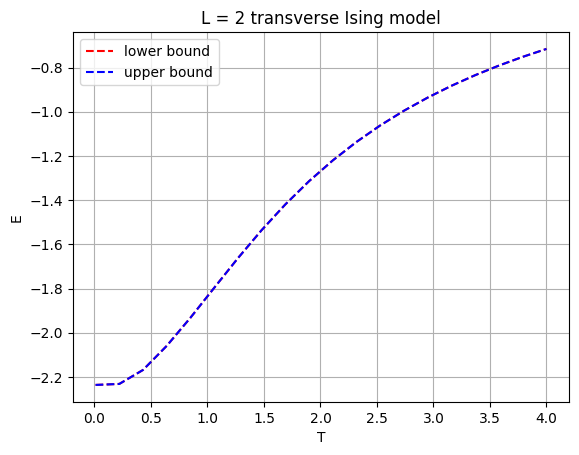

In [18]:
plt.fill_between(1/betas, mins, -maxs, alpha = 0.5)
plt.plot(1/betas, mins,c ='red',linestyle='--',label='lower bound')
plt.plot(1/betas, -maxs,c ='blue',linestyle='--',label='upper bound')
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'L = {L} transverse Ising model')
plt.legend()
plt.grid()
plt.show()